<a href="https://colab.research.google.com/github/saadz-khan/Text2Image/blob/master/pixray_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

follow me on twitter: [@dazhizhong](https://twitter.com/DazhiZhong) and find me on [Github](https://github.com/dazhiZhong)

# setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#@title Setup

#@markdown Please execute this cell by pressing the _Play_ button 
#@markdown on the left. You should only need to run this part once.

#@markdown **Note**: This installs the software on the Colab 
#@markdown notebook in the cloud and not on your computer.

#@markdown When complete you will need to do Runtime -> Restart Runtime from the menu

# Add a gpu check
nvidia_output = !nvidia-smi --query-gpu=memory.total --format=noheader,nounits,csv
gpu_memory = int(nvidia_output[0])
if gpu_memory < 14000:
  print(f"--> GPU check: ONLY {gpu_memory} MiB available: WARNING, some things might not work <--")
else:
  print(f"GPU check: {gpu_memory} MiB available: this should be fine")

print("Installing...")
from IPython.utils import io
with io.capture_output() as captured:
  !rm -Rf pixray
  !git clone --recursive https://github.com/pixray/pixray
  !pip install -r pixray/requirements.txt
  !pip uninstall -y tensorflow 
  !git clone https://github.com/pixray/diffvg
  %cd diffvg
  !git submodule update --init --recursive
  !python setup.py install
  %cd ..
  !pip freeze | grep torch

import os
if not os.path.isfile("first_init_complete"):
  # put stuff in here that should only happen once
  !mkdir -p models
  os.mknod("first_init_complete")
  print("Please choose Runtime -> Restart Runtime from the menu to continue!")
else:
  print("Setup Complete! Good luck with your drawing")


GPU check: 16280 MiB available: this should be fine
Installing...
Please choose Runtime -> Restart Runtime from the menu to continue!


In [ ]:
#@title Installing/Setup { vertical-output: true }
!pip3 install opencv-python==4.2.0.32
!pip3 install vispy==0.6.4
!pip3 install moviepy==1.0.2
!pip3 install transforms3d==0.3.1
!pip3 install networkx==2.3
!sudo apt install sed
!git clone https://github.com/dazhizhong/3d-photo-inpainting.git
%cd 3d-photo-inpainting
!git checkout 20361ff
!sh download.sh
#!sed -i 's/offscreen_rendering: True/offscreen_rendering: False/g' argument.yml
%cd ..
!rm -rf pixray
!git clone  https://github.com/pixray/pixray.git
!cd pixray && git checkout de99b86
!pip install -r pixray/requirements.txt
!pip uninstall -y tensorflow 
!git clone https://github.com/pixray/diffvg
%cd diffvg
!git checkout c40ec08
!git submodule update --init --recursive
!python setup.py install
%cd ..
!pip freeze | grep torch
!mkdir models
exit()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
sed is already the newest version (4.4-2).
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-11-1
  cu

# main

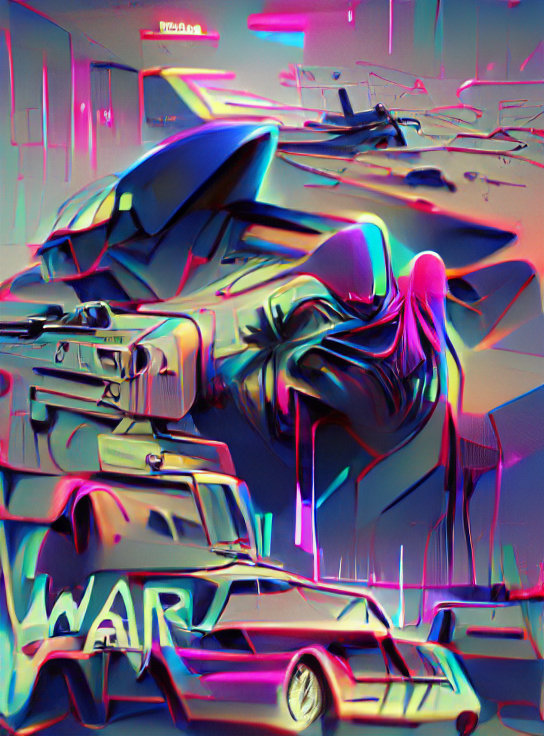

iter: 100, finished (-20=>5.633)



FileNotFoundError: ignored

In [6]:
#@title Generate image from prompt { vertical-output: true }
import sys
import regex as re
import os
sys.path.append("pixray")
import pixray

punctuations = '''|!()-[]{};:'"\,<>./?@#$%^&*_~'''

prompts = "war | synthwave style trending on artstation" #@param {type:"string"}
#drawer = "vqgan"

no_punct = ""
for char in prompts:
   if char not in punctuations:
       no_punct = no_punct + char

init_image = ""#@param {type:"string"}
#init_image = re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', init_image)
#init_image = re.findall('^/[\w\.\-]+$', init_image)

target_image = ""#@param {type:"string"}
#target_image = re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', init_image)

batches = 1

if not init_image:
  init_image = None

if not target_image:
  target_image = None

drawer = "vqgan" #@param ["vqgan", "pixel", "vdiff"]

video = False #@param {type:"boolean"}

display_clear = True #@param {type:"boolean"}

iterations = 100 #@param {type:"number"}

pixel_scale = 1 #@param {type:"slider", min:0.25, max:2.0, step:0.25}

#num_cuts = 28 #@param {type:"slider", min:8, max:32, step:4}

#clip_models = #@param ["RN101","RN50x4","ViT-B/16", "ViT-B/32", "all"]

#if clip_models == "all":
  #clip_models = ["RN101","RN50x4","ViT-B/16", "ViT-B/32"]
quality = 'best' #@param ["normal", "better", "best", "supreme"]

optimiser = 'Adam' #@param ["Adam", "DiffGrad"]

palette = False #@param {type:"boolean"}
if palette:
  use_palette = "[#000000, #071008, #0e2011, #153019, #1c4022, #23502a, #2a6033, #31703b, #388044, #3f8f4c, #469f54, #4daf5d, #54bf65, #5bcf6e, #62df76, #69ef7f];black->white" #@param {type:"string"}


pixray.reset_settings()
pixray.add_settings(prompts=prompts)
pixray.add_settings(quality=quality,
                    size=[544,750],
                    iterations=iterations,
                    drawer=drawer,
                    display_clear=display_clear,
                    make_video=video,
                    scale = pixel_scale,
                    optimiser = optimiser,
                    init_image = init_image
                    )

settings = pixray.apply_settings()
pixray.do_init(settings)
pixray.do_run(settings)

os.rename('output.png', f'{no_punct}.png')
!rm -rf ./output.png
if video:
  os.rename('output.mp4', f'{no_punct}.mp4')
  !rm -rf ./output.mp4

In [ ]:
import torch
torch.cuda.empty_cache()

import shutil
# shutil.copy("output.png","3d-photo-inpainting/image")

from PIL import Image
import os
import glob
for f in glob.glob("3d-photo-inpainting/image/*.*"):
    os.remove(f)
im = Image.open(settings.output)
im.save(f"3d-photo-inpainting/image/input.jpg")


import time
begin = time.time()
for f in glob.glob("3d-photo-inpainting/video/*.*"):
    os.remove(f)
%cd 3d-photo-inpainting 
!python main.py --config argument.yml
%cd ..
print(f"finished in {time.time() - begin}")


from IPython import display
import glob
from PIL import Image
from IPython.display import HTML
from base64 import b64encode
from IPython.utils import io

fps = glob.glob("3d-photo-inpainting/video/*")
for f in fps:
    mp4 = open(f,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    # display.clear_output()
    display.display(HTML("""
    <video height=350 controls loop autoplay>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url))